<a href="https://www.kaggle.com/redomy/birdclef-2022-spectrum-custom-data-pytorch?scriptVersionId=89946465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
import torchaudio
from torch.utils.data import Dataset
from torchvision.transforms import Resize

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename[-3:]!='ogg':
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/birdclef-2022/sample_submission.csv
/kaggle/input/birdclef-2022/scored_birds.json
/kaggle/input/birdclef-2022/eBird_Taxonomy_v2021.csv
/kaggle/input/birdclef-2022/test.csv
/kaggle/input/birdclef-2022/train_metadata.csv


In [2]:
sample_submission = pd.read_csv('/kaggle/input/birdclef-2022/sample_submission.csv')
#scored_birds = pd.read_csv('/kaggle/input/birdclef-2022/scored_birds.json')
taxonomy = pd.read_csv('/kaggle/input/birdclef-2022/eBird_Taxonomy_v2021.csv')
test = pd.read_csv('/kaggle/input/birdclef-2022/test.csv')
train_metadata = pd.read_csv('/kaggle/input/birdclef-2022/train_metadata.csv')

In [3]:
train_metadata.head(5)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


# Birds species in danger

If we suppose that the occurence of each bird species in this dataset is correlated to its extinction rate, we can get an idea of which species are endagered and which species are not. 

In [4]:
import plotly.express as px
import geopandas as gpd

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


geo_df = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

#px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_geo(geo_df,
                    lat=train_metadata['latitude'],
                    lon=train_metadata['longitude'],
                    color = train_metadata['primary_label'],
                    hover_name=train_metadata['primary_label'])
fig.show()

<AxesSubplot:title={'center':'birds in danger of extinction'}>

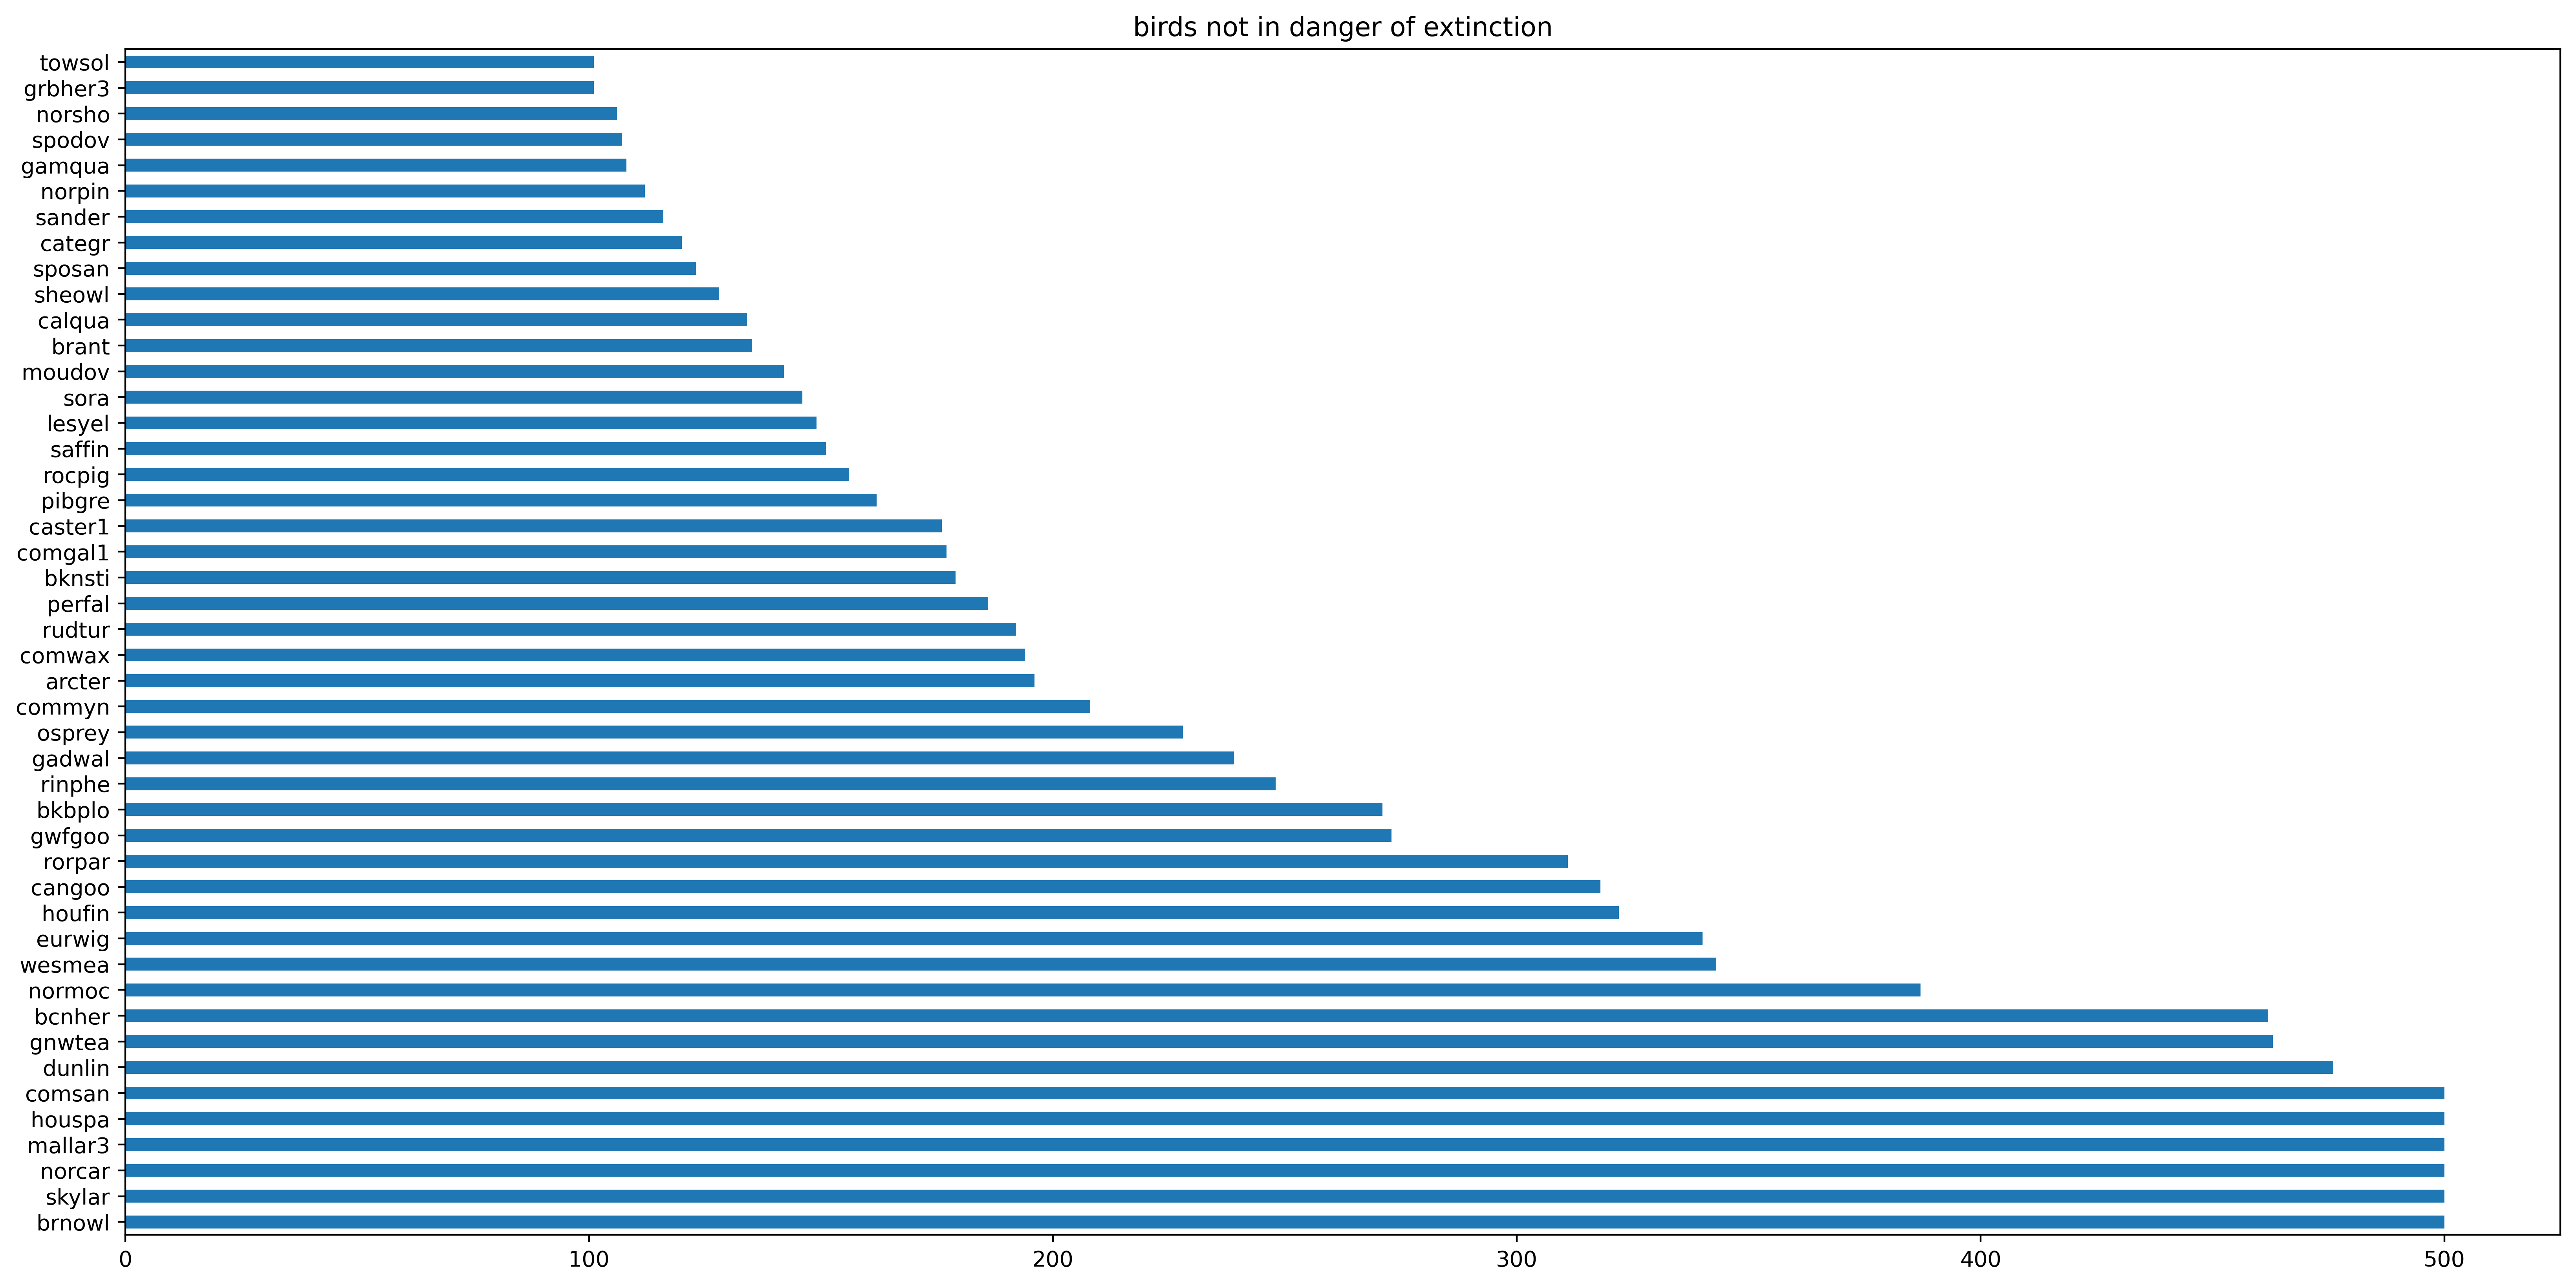

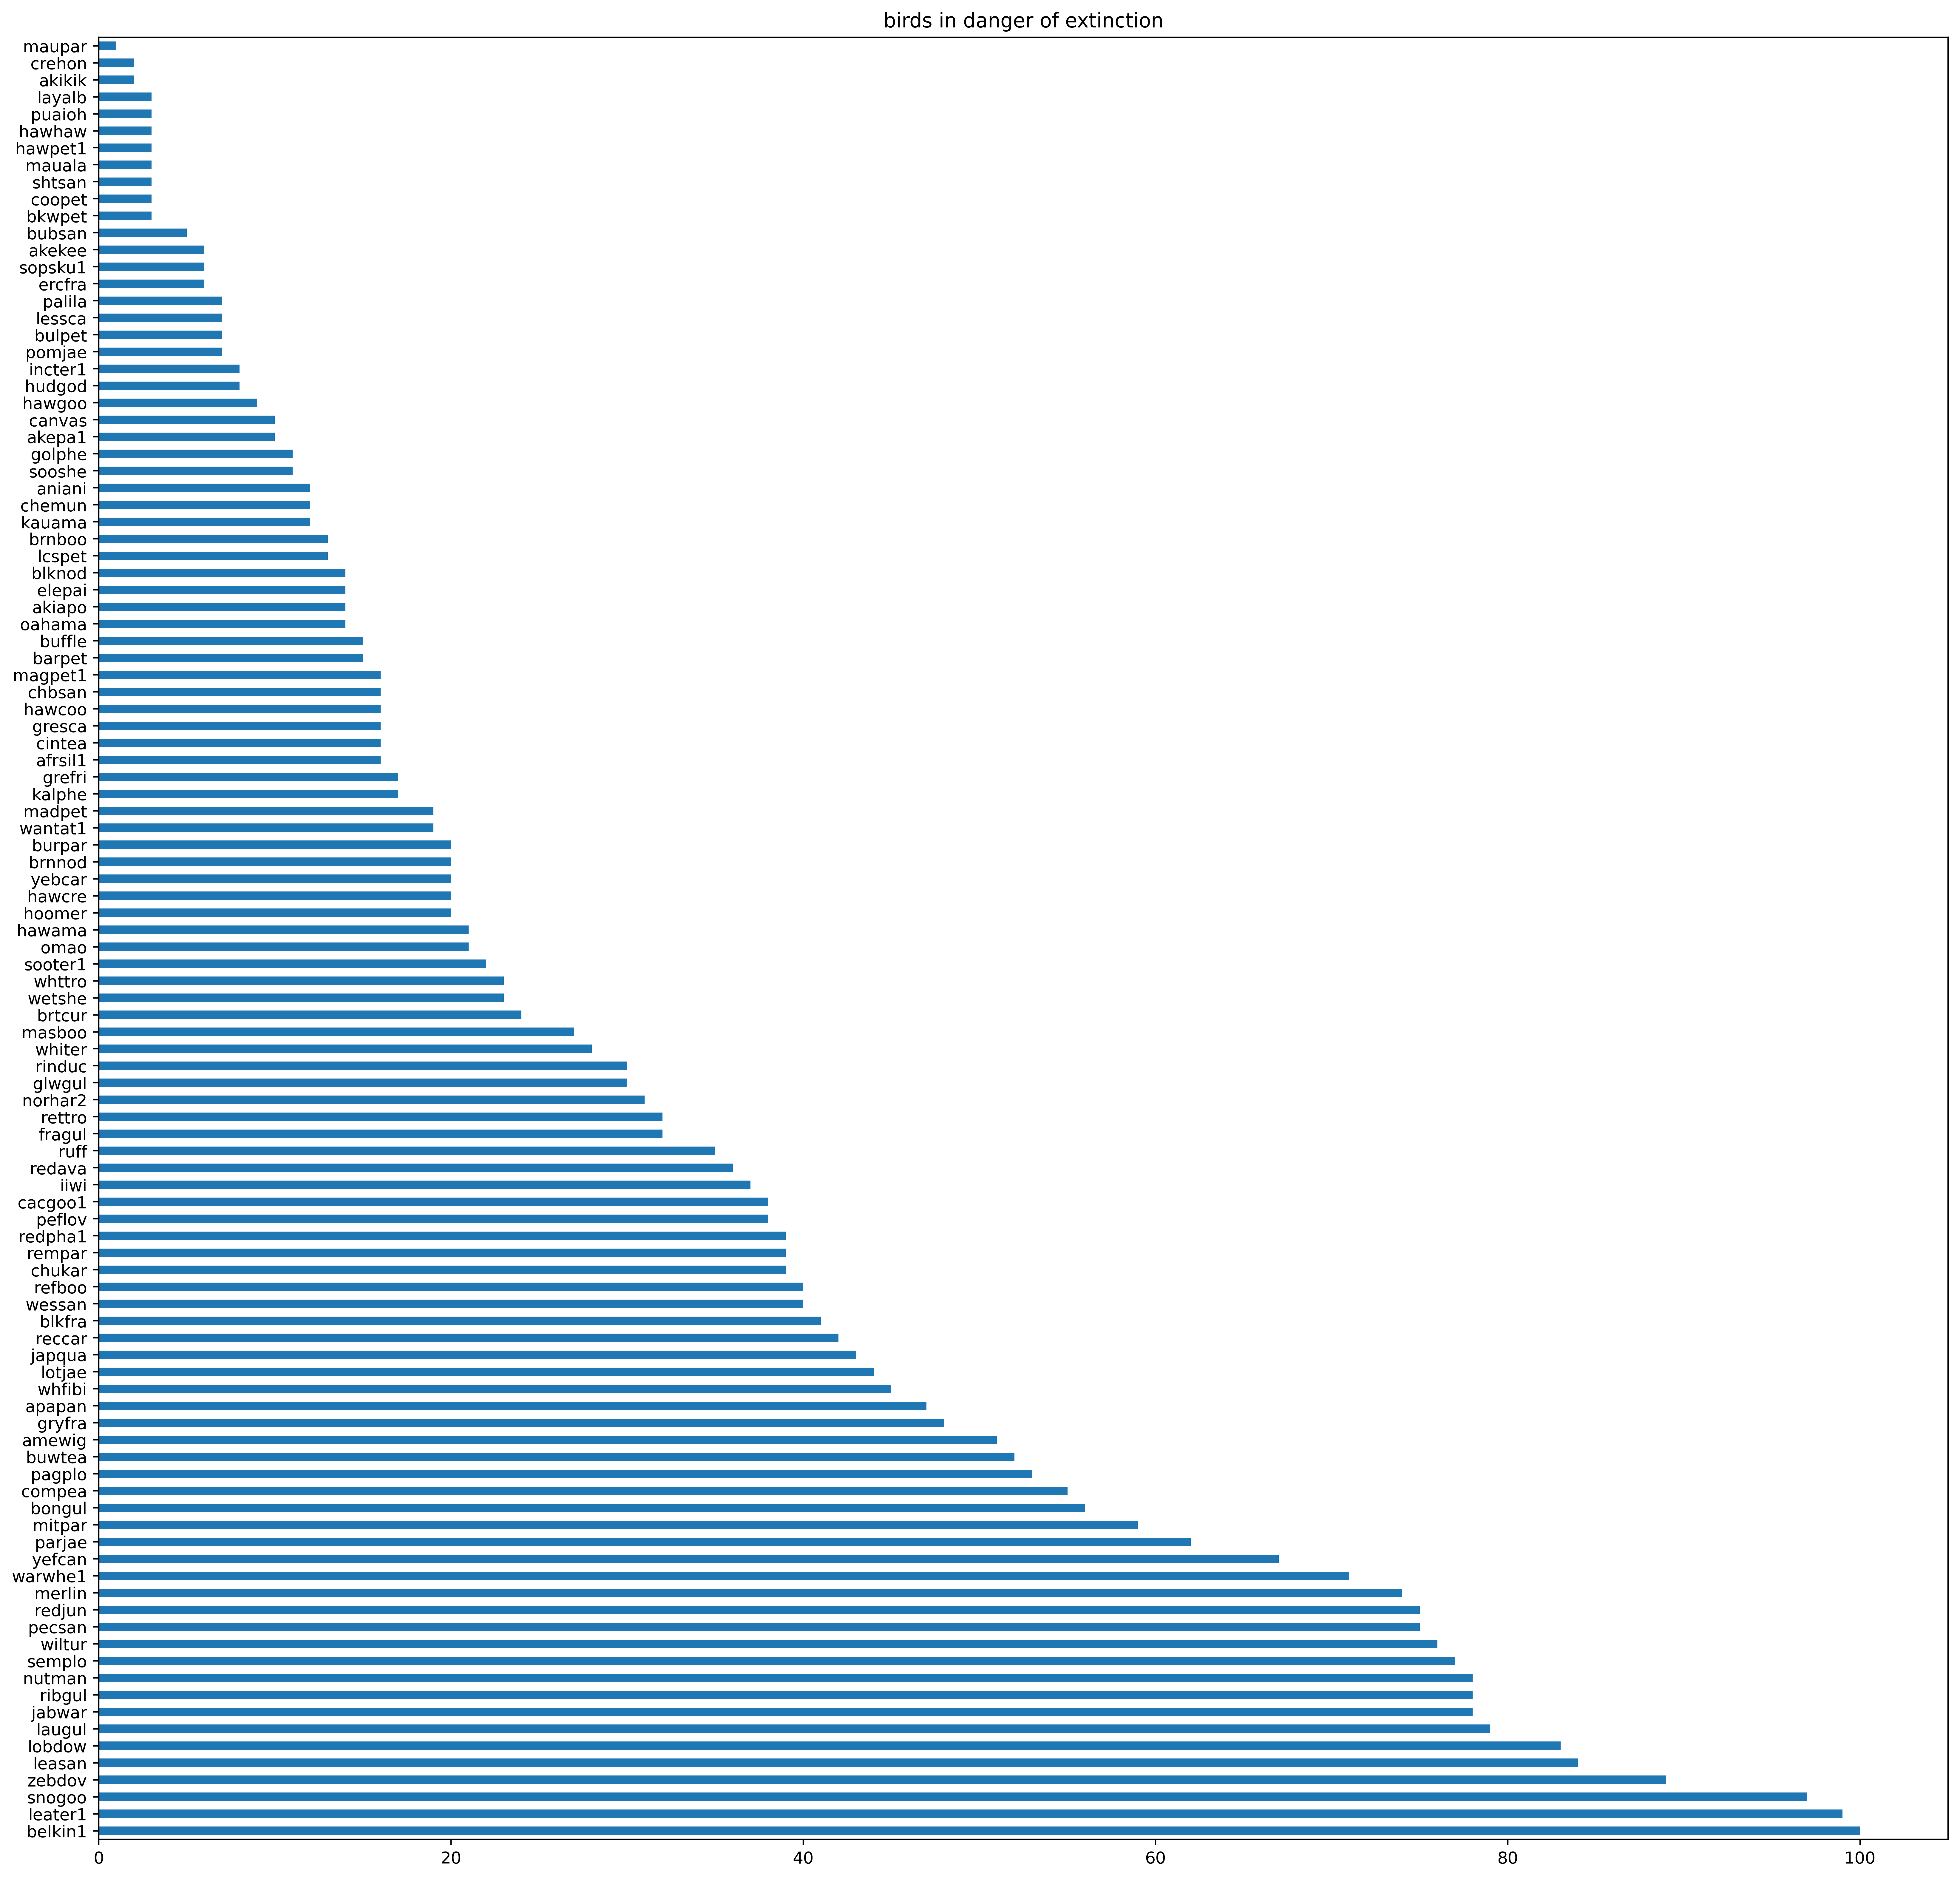

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10),dpi=400)
count = train_metadata['primary_label'].value_counts()
count[count.values>100].plot(kind='barh', title='birds not in danger of extinction')
plt.figure(figsize=(20,20),dpi=400)
count[count.values<=100].plot(kind='barh', title='birds in danger of extinction')

#count = count.plot(kind = 'barh')
#sns.countplot(train_metadata['primary_label'])

# Time plot of a bird's chirp

torch.Size([1, 555872])
torch.Size([1, 555872])
sample rate: 32 khz


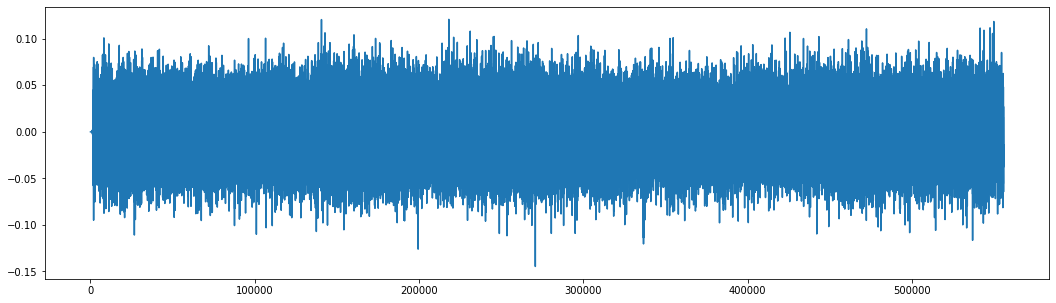

In [6]:
# pick a random file and plot it
file_index = 290

sound = r'/kaggle/input/birdclef-2022/train_audio/'+ train_metadata['filename'][file_index]
wf, sr = torchaudio.load(sound)
print(wf.shape)
wft = wf.t().numpy() # convert from tensor to numpy
print(wf.shape)
print('sample rate:', sr//1000, 'khz')
plt.figure(figsize=(18,5))
plt.plot(wft)

# Mel Spectrogram with torchaudio

To get the Mel spectrogram, we first apply MelSpectrogram transform from toraudio, then calculate the log2 value of the result to get values in db.

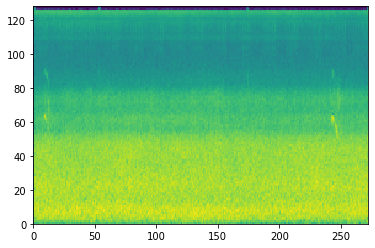

In [7]:
# Mel spectrom with torch
specgram = torchaudio.transforms.MelSpectrogram(n_fft=4096)(wf)
specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
plt.pcolormesh(specgram[0])

# Mel spectrogram with Scipy

In [8]:
# Mel spectrom with scipy
def spectrogram(xs):
    f, t, spec = signal.spectrogram(xs, fs=sr, nfft=256, window=('hann'))
    wave_sxx_graph = np.log2(np.absolute(spec))
    return f,t,wave_sxx_graph

(129, 2481)
(129,)
(2481,)


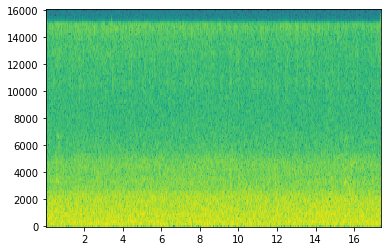

In [9]:
# Calculate spectrogram using math
t,f,wave_sxx_graph = spectrogram(wft[:,0])
print(wave_sxx_graph.shape)
print(t.shape)
print(f.shape)
#plt.figure(0)
plt.pcolormesh(f,t, wave_sxx_graph)
#plt.figure(1)
#plt.pcolormesh(t, f, spec[1,:])
#plt.show()

# DataLoader and transforms Pytorch

In [10]:
annotation_file = r'/kaggle/input/birdclef-2022/train_metadata.csv'
chirp_dir = r'/kaggle/input/birdclef-2022/train_audio'
class CustomChirpDataset(Dataset):
    def __init__(self, annotations_file, chirp_dir, transform=None, target_transform=False):
        self.metadata = pd.read_csv(annotations_file)
        self.chirp_labels = self.metadata['filename']
        self.chirp_dir = chirp_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.chirp_labels)

    def __getitem__(self, idx):
        chirp_path = os.path.join(self.chirp_dir, self.chirp_labels.iloc[idx])
        chirp, sr = torchaudio.load(chirp_path)
        label = self.chirp_labels.iloc[idx]
        if self.transform:
            spec = self.melspectrogram(chirp)
        if self.target_transform:
            label = self.encode_label(label)
        return spec, label
    def encode_label(self,label):
        label,filename = os.path.split(label)
        return label
    def melspectrogram(self,chirp):
        spectrum = torchaudio.transforms.MelSpectrogram(n_fft = 1000, n_mels=128)(chirp)
        spectrum = torchaudio.transforms.AmplitudeToDB()(spectrum)
        spectrum = torch.unsqueeze(spectrum, dim=0)
        # resize input to so all spectrograms have the same (128,128)
        spectrum = Resize((128, 128))(spectrum)
        return spectrum[0,0,:,:]

## Test dataloader

torch.Size([128, 128])


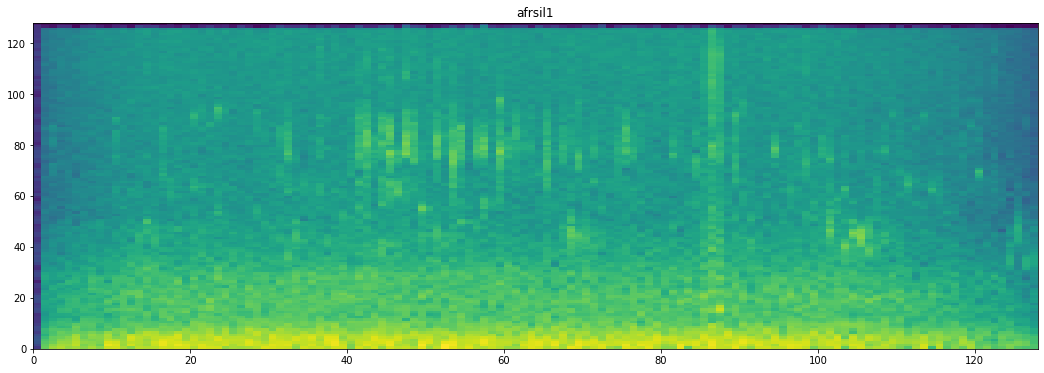

torch.Size([128, 128])


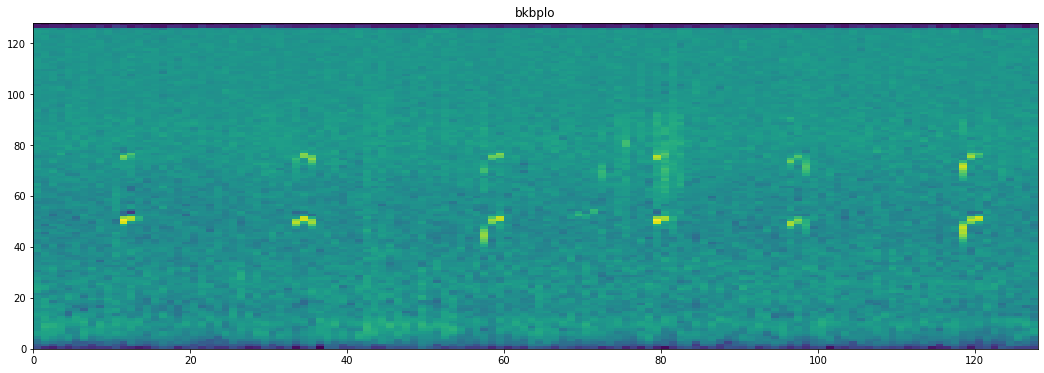

torch.Size([128, 128])


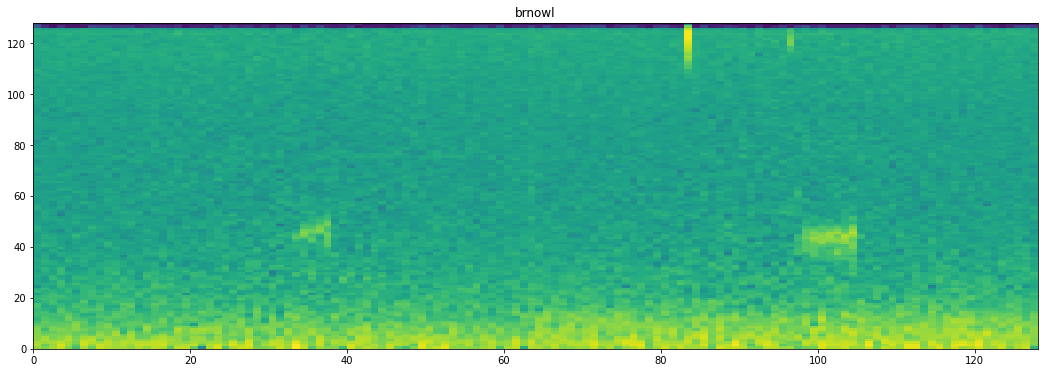

torch.Size([128, 128])


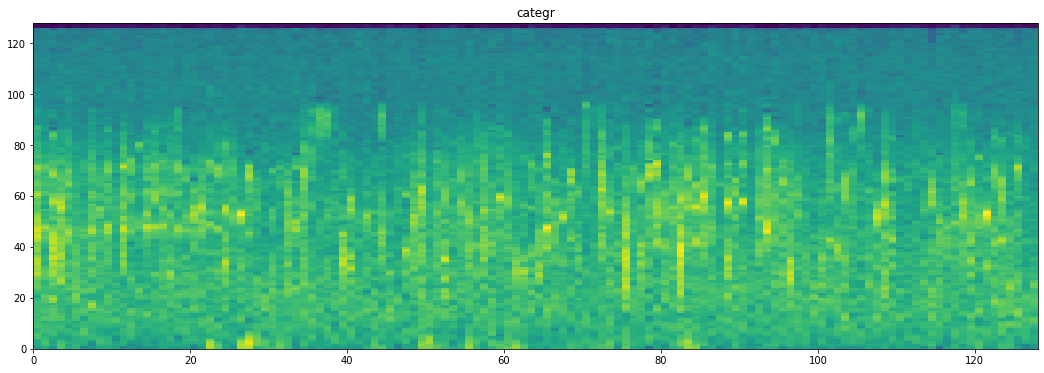

torch.Size([128, 128])


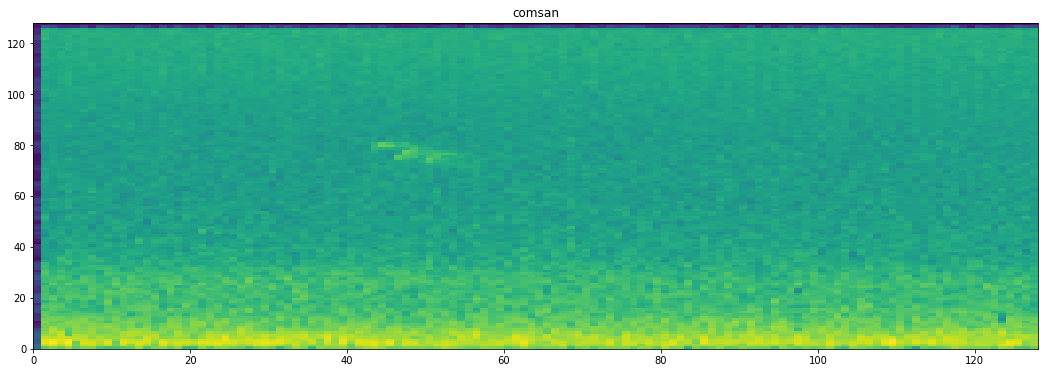

torch.Size([128, 128])


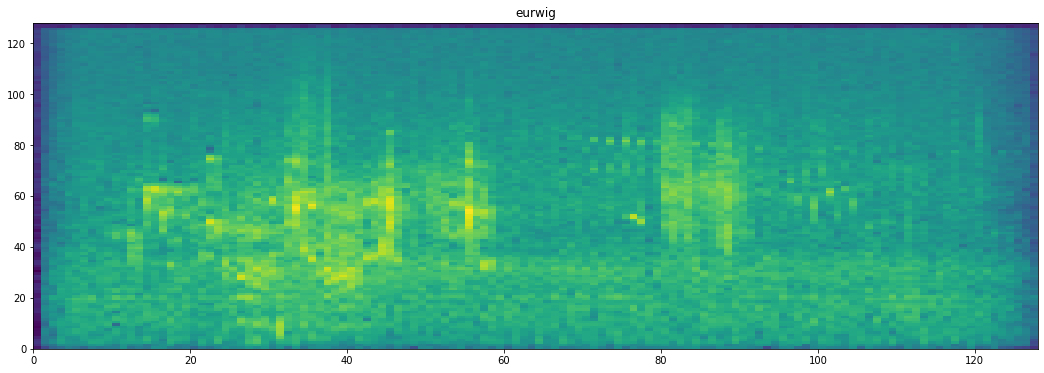

In [11]:
# init dataset
dataset = CustomChirpDataset(annotation_file, chirp_dir, transform=True, target_transform=True)
for j in [0,1000,2000,3000,4000,5000]:
    #plt.subplot(1,6, j//1000 +1)
    plt.figure(figsize = (18,6))
    # select some chirp
    chirp,label = dataset.__getitem__(j)
    print(chirp.shape)
    plt.pcolormesh(chirp)
    plt.title(label)
    plt.show()